In [1]:
from utils import *

In [2]:
%%time

train = pd.read_parquet('data_fusion_train.parquet')

Wall time: 18.4 s


In [7]:
train.reset_index(inplace=True)

In [8]:
train['orig_label'] = True

### Pseudoaugmenting array

In [9]:
import pickle


tfidf = pickle.load(open('tfidf', 'rb'))
clf = pickle.load(open('log_reg_clf', 'rb'))

unlabeled = train[train.category_id == -1]
unlabeled.shape

c:\Users\rinat\Projects\birdClassification\myenv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
c:\Users\rinat\Projects\birdClassification\myenv\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'log_reg_clf'

In [6]:
unlabeled.head()

,index,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,orig_label
0,0,7,5,09:50,Флуконазол капс 150мг №1 Вертекс,1.0,7,-1,-1,вертекс,True
2,2,39,4,11:28,"Борщ Станичный с тушенкой, 103 ккал (завод, з/у)",1.0,6,1,-1,None,True
5,6,39,4,11:28,"Филе Горизонт (филе птицы), 218 ккал",1.0,7,1,-1,горизонт,True
6,10,49,3,14:27,3 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None,True
7,11,49,3,14:27,4 Бумага Упак 1/Прочи/В асс,1.0,8,1,-1,None,True


In [7]:
%%time

BATCH_SIZE = 1000000
from tqdm import tqdm

cnt_changed = 0

for i in range(unlabeled.size//BATCH_SIZE):
    cur_df = unlabeled.iloc[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    X_test = tfidf.transform(cur_df.item_name)
    pred = clf.predict_proba(X_test)
    one_axis_max = np.argmax(pred, axis=1)
    idx = cur_df.index.tolist()
    for id_, cur in tqdm(enumerate(one_axis_max)):
        if (pred[id_][cur] > 0.98):
            assert train.iloc[idx[id_]].category_id == -1
            train.at[idx[id_], 'category_id'] = clf.classes_[cur]
            train.at[idx[id_], 'orig_label'] = False
            cnt_changed += 1
    print('N changed:', cnt_changed)
    

1000000it [00:08, 118347.00it/s]


N changed: 61453


1000000it [00:08, 118487.00it/s]


N changed: 123146


1000000it [00:08, 119239.93it/s]


N changed: 184318


1000000it [00:08, 118129.65it/s]


N changed: 245805


1000000it [00:08, 117873.15it/s]


N changed: 307388


1000000it [00:08, 119535.49it/s]


N changed: 368690


1000000it [00:08, 118931.39it/s]


N changed: 430157


1000000it [00:08, 119271.43it/s]


N changed: 491507


1000000it [00:08, 116853.91it/s]


N changed: 552502


1000000it [00:08, 120191.83it/s]


N changed: 613399


1000000it [00:08, 119517.71it/s]


N changed: 674941


1000000it [00:08, 120203.34it/s]


N changed: 736190


1000000it [00:08, 118418.51it/s]


N changed: 797831


1000000it [00:08, 118134.44it/s]


N changed: 859183


1000000it [00:08, 118331.22it/s]


N changed: 920522


1000000it [00:08, 117257.20it/s]


N changed: 982055


1000000it [00:08, 115538.05it/s]


N changed: 1043317


1000000it [00:08, 115297.65it/s]


N changed: 1104744


1000000it [00:08, 116154.62it/s]


N changed: 1165974


610851it [00:05, 115878.44it/s]


N changed: 1203715


ValueError: Found array with 0 sample(s) (shape=(0, 154685)) while a minimum of 1 is required.

In [8]:
train.to_csv('labeled.csv', index=False)

<AxesSubplot:ylabel='category_id'>

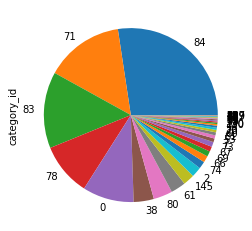

In [10]:
train[train.orig_label == False].category_id.value_counts().plot.pie()

<AxesSubplot:ylabel='category_id'>

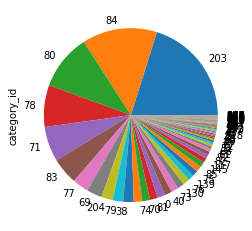

In [14]:
train[(train.orig_label == True) & (train.category_id != -1)].category_id.value_counts().plot.pie()

In [18]:
train

receipt_id                                                      129
receipt_dayofweek                                                 3
receipt_time                                                  15:17
item_name            ЛанчБаскет 5 за 300: 2 шт ОРИГ Стрипсы кур фил
item_quantity                                                     1
item_price                                                        8
item_nds_rate                                                     2
category_id                                                      69
brands                                                         None
Name: 58, dtype: object

### Processing Train

In [5]:
train = train[train.category_id != -1]
train

,index,receipt_id,receipt_dayofweek,receipt_time,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,orig_label
1,1,11,6,20:34,"Молоко 3,2%,шт",2.0,8,2,78,None,True
3,3,39,4,11:28,"Компот из изюма, 114 ккал",1.0,4,1,71,None,True
4,4,39,4,11:28,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None,True
12,17,56,5,11:42,Кофе Капучино Большой Эден 18,1.0,12,1,70,None,True
24,40,105,3,01:53,Хлеб на СЫВОРОТКЕ 350г,1.0,7,-1,84,None,True
...,...,...,...,...,...,...,...,...,...,...,...
26094041,45729256,10016106,6,12:18,Мороженое ЗОЛОТОЙ СТАНДАРТ рож,1.0,9,2,73,None,True
26094047,45729264,10016106,6,12:18,Пакет,1.0,3,1,203,None,True
26094054,45729277,10016136,6,17:08,Пакет,1.0,3,1,203,None,True
26094055,45729279,10016149,1,11:08,Печень по-строгановски,1.0,8,1,71,None,True


In [6]:
train['rec_hour'] = train['receipt_time'].apply(lambda x: int(x.split(':')[0]))
train['rec_minute'] = train['receipt_time'].apply(lambda x: int(x.split(':')[1]))
train = train.drop(['receipt_time'], axis=1, errors='ignore')

In [7]:
train.head()

,index,receipt_id,receipt_dayofweek,item_name,item_quantity,item_price,item_nds_rate,category_id,brands,orig_label,rec_hour,rec_minute
1,1,11,6,"Молоко 3,2%,шт",2.0,8,2,78,None,True,20,34
3,3,39,4,"Компот из изюма, 114 ккал",1.0,4,1,71,None,True,11,28
4,4,39,4,"Макаронные изделия отварные (масло сливочное),...",1.0,4,1,71,None,True,11,28
12,17,56,5,Кофе Капучино Большой Эден 18,1.0,12,1,70,None,True,11,42
24,40,105,3,Хлеб на СЫВОРОТКЕ 350г,1.0,7,-1,84,None,True,1,53


In [8]:
%%time

train['weight'] = 1
train_unique = train.groupby('item_name').agg(
    {'category_id': 'first', 'weight': 'sum', 'brands': 'first', 
'rec_hour': 'mean', 'rec_minute': 'mean', 'item_quantity': 'mean', 
'receipt_dayofweek': 'mean', 'item_price':'mean', 'item_nds_rate' : 'first'}
).reset_index()

Wall time: 2.24 s


In [9]:
class_weights = train.groupby('category_id').agg({'weight': 'sum'})
class_weights /= class_weights.sum()

class_weights = class_weights.sort_values('weight', ascending=False)
class_weights

,weight
category_id,
203,2.016373e-01
84,1.392065e-01
80,1.034721e-01
78,7.761553e-02
71,6.510416e-02
...,...
106,2.822669e-05
97,1.681262e-05
46,1.033436e-05


In [10]:
del train

### Creating Train Array

In [9]:
tfidf = TfidfVectorizer(ngram_range = (1, 2), max_features=5000)
brands_train = tfidf.fit_transform(train_unique.item_name)
brands_train.shape

(48225, 5000)

In [24]:
%%time

stop = stopwords.words('russian')

tfidf = TfidfVectorizer(ngram_range = (1,2))
items_train = tfidf.fit_transform(train_unique.item_name)
y_train = train_unique['category_id']
#items_train.shape
X_train = items_train

Wall time: 2.71 s


In [9]:
num_features_train = train_unique[['receipt_dayofweek','item_quantity','item_price','item_nds_rate','rec_hour','rec_minute']].to_numpy()
num_features_train.shape

(48225, 6)

In [11]:
items_train

<48225x154685 sparse matrix of type '<class 'numpy.float64'>'
	with 384397 stored elements in Compressed Sparse Row format>

In [25]:
import scipy.sparse


X_train = items_train # scipy.sparse.hstack([items_train, num_features_train])
X_train.shape

(196141, 346753)

In [75]:
from scipy.sparse import coo_matrix

X_train = X_train.tocsr()
X_train

<48225x154685 sparse matrix of type '<class 'numpy.float64'>'
	with 384397 stored elements in Compressed Sparse Row format>

### Augmenting Train

In [17]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler 

val_counted = train_unique.category_id.value_counts()
keys = [i for i in val_counted.index.tolist()]
vals_counted = val_counted.tolist()

mapping = {}
for key, val in zip(keys, vals_counted):
    mapping[key] = int(val*2)

mapping

{84: 14188,
 71: 9542,
 78: 5738,
 83: 5730,
 0: 4712,
 38: 4538,
 80: 3700,
 77: 2380,
 204: 2292,
 81: 2268,
 73: 2218,
 61: 2116,
 74: 2022,
 70: 1774,
 130: 1754,
 79: 1630,
 75: 1484,
 85: 1348,
 76: 1136,
 40: 1104,
 139: 1102,
 82: 1094,
 117: 1066,
 145: 960,
 69: 882,
 114: 866,
 140: 662,
 51: 646,
 2: 632,
 118: 628,
 120: 628,
 45: 624,
 49: 616,
 67: 612,
 43: 608,
 30: 592,
 72: 576,
 57: 492,
 66: 474,
 52: 472,
 107: 470,
 109: 460,
 4: 450,
 7: 448,
 50: 436,
 36: 378,
 12: 364,
 60: 360,
 133: 356,
 68: 350,
 115: 338,
 62: 310,
 92: 298,
 105: 264,
 29: 258,
 53: 252,
 37: 248,
 177: 238,
 3: 218,
 9: 208,
 103: 192,
 42: 190,
 138: 182,
 167: 182,
 128: 180,
 54: 178,
 150: 162,
 41: 158,
 108: 150,
 164: 148,
 19: 148,
 24: 136,
 58: 134,
 6: 128,
 20: 118,
 203: 118,
 111: 116,
 90: 100,
 11: 94,
 55: 94,
 96: 90,
 163: 86,
 39: 84,
 31: 76,
 27: 76,
 13: 74,
 106: 72,
 56: 68,
 1: 56,
 35: 50,
 26: 44,
 102: 38,
 101: 34,
 46: 30,
 100: 28,
 97: 26}

In [18]:
pd.Series(mapping.values()).describe()

count       96.000000
mean      1004.687500
std       1990.675861
min         26.000000
25%        135.500000
50%        358.000000
75%        901.500000
max      14188.000000
dtype: float64

In [33]:
ros = RandomOverSampler(mapping,  random_state=42)
X_res, y_res = ros.fit_resample(X_train, train_unique.category_id)

In [17]:
X_res.shape

(60243, 154685)

### Training Model

In [11]:
class_weights = class_weights.to_dict()['weight']

In [33]:
from sklearn.metrics import f1_score, make_scorer
import numpy as np

def f1_weighted(y, p):
    resulted_f1 = []
    for c in y.unique():
        f1 = f1_score(y == c, p == c)
        resulted_f1.append(f1 * class_weights[c])
        
    return np.sum(resulted_f1) 

f1_weighted_sc = make_scorer(f1_weighted)

In [34]:
%%time

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

clf = LinearSVC()

N_JOBS=3
scores = cross_val_score(clf, X_train, y_train, cv=N_JOBS, scoring=f1_weighted_sc, n_jobs=N_JOBS)


KeyError: 84

In [19]:
scores.mean(), scores.std()

AttributeError: module 'nltk.metrics.scores' has no attribute 'mean'

In [29]:
from sklearn.svm import LinearSVC
clf = LinearSVC()

In [30]:
%%time

_ = clf.fit(X_train, y_train)

Wall time: 49.5 s


In [23]:
import pickle

pickle.dump(clf, open('log_reg_clf', 'wb'))

In [31]:
import pickle

pickle.dump(tfidf, open('tfidf', 'wb'))
pickle.dump(clf, open('clf_task1', 'wb'))

In [12]:
!ls -lh t1_sub

итого 12M
-rw-r--r-- 1 dmitry.dremov dmitry.dremov  312 янв 30 21:37 answers.csv
-rw-r--r-- 1 dmitry.dremov dmitry.dremov 7,4M янв 30 21:38 clf_task1
drwxr-xr-x 2 dmitry.dremov dmitry.dremov 4,0K янв 30 18:06 data
-rw-r--r-- 1 dmitry.dremov dmitry.dremov  352 янв 30 18:11 script.py
-rw-r--r-- 1 dmitry.dremov dmitry.dremov 2,9M янв 30 21:38 submission.zip
-rw-r--r-- 1 dmitry.dremov dmitry.dremov 1,3M янв 30 21:38 tfidf


In [42]:
import zipfile 
compression = zipfile.ZIP_DEFLATED

submission_name = 't1_sub/submission.zip'
with zipfile.ZipFile(submission_name, 'w') as zipObj:
    for filename in [
        'clf_task1',
        'tfidf',
        'script.py',
    ]:
        zipObj.write(
            f't1_sub/{filename}', 
            arcname=filename, 
            compress_type=compression
        )
    print(zipObj.namelist())

!ls -lh {submission_name}

FileNotFoundError: [Errno 2] No such file or directory: 't1_sub/submission.zip'

# Debug run

In [14]:
!cd t1_sub; python3 script.py

In [15]:
pd.read_csv('t1_sub/answers.csv').head(5)

,id,pred
0,0,80
1,1,204
2,2,204
3,3,71
4,4,79
